In [25]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
from selenium.common.exceptions import NoSuchElementException
from datetime import datetime
from queue import Queue

from collections import Counter
from nltk.corpus import stopwords
from gensim import corpora, models
from gensim.models import CoherenceModel
from collections import defaultdict

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import requests
from bs4 import BeautifulSoup

In [26]:
def scrape_article(url):
    response = requests.get(str(url))
    soup = BeautifulSoup(response.content, 'html.parser')

    title = ''
    date = ''
    content =''

    try:
        title = soup.find('h1', attrs={'class': 'entry-title'}).text.strip()
        date = soup.find('span', attrs={'class': 'item-metadata posts-date'}).text.strip()
        try:
            content_raw = soup.find('div', attrs={'class': 'entry-content read-details'}).text.strip()
            delimiter = 'Continue Reading'
            content = content_raw.split(delimiter)[0]
        except NoSuchElementException:
            pass
    except NoSuchElementException:
        pass

    if len(title) == 0 or len(date) == 0  or len(content) == 0 :
        return ['empty', 'empty', 'empty']
    else:
        return [title, date, content]

In [3]:
def mc_navigate_scrape_website(user_input_date):
    user_input_date = str(user_input_date)

    url = 'https://www.baguiomidlandcourier.com.ph/category/city/'
    counter = 0

    links = []

    while (url is not None) and (counter != 10):
        try:
            response = requests.get(url)
            soup = BeautifulSoup(response.content, 'html.parser')
            main_container = soup.find('div', attrs={'id': 'aft-archive-wrapper'})

            for news_div in soup.find_all('div', attrs={'class' : 'col-66 float-l pad read-details color-tp-pad'}):
                news_div_date = news_div.find('span', attrs={'class' : 'item-metadata posts-date'}).text.strip()
                news_div_date_formatted = datetime.strptime(news_div_date, '%B %d, %Y').strftime('%Y-%m-%d')

                if user_input_date == news_div_date_formatted:
                    news_div_title = news_div.find('div', attrs={'class' : 'read-title'})
                    news_div_h4 = news_div_title.find('h4')
                    news_div_href = news_div_h4.find('a').get('href')
                    links.append(news_div_href)

            next_page_url = soup.find('a', attrs={'class' : 'next page-numbers'}).get('href')
            if next_page_url is not None:
                url = str(next_page_url)
            else:
                url = None

            counter += 1
        except:
            pass

    bmc_news = {'title': [], 'date': [], 'content': []}
    for url in links:
        bmc_news_list = scrape_article(url)
        bmc_news['title'].append(bmc_news_list[0])
        bmc_news['date'].append(user_input_date)
        bmc_news['content'].append(bmc_news_list[2])

    if bmc_news:
        return bmc_news
    else:
        return ['No data']

In [27]:
def preprocess_text(text, threshold=2):
    months = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
    html_tags = ["!DOCTYPE", "html", "head", "title", "body", "h1", "h2", "h3", "h4", "h5", "p", "br", "hr", "!--...--", "span", "rgb", "style", "label", "input", "textarea", "button", "select"]
    common_words = ["baguio", "color", "city"]

    # Instantiate stop words
    stop_words = stopwords.words('english')
    stop_words.extend(months)
    stop_words

    # Lowercase
    text = text.lower()
    # Remove numbers and punctuation
    text = re.sub(r'[^a-zA-Z]+', ' ', text)
    # Remove months and people names
    
    # Tokenize words
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in common_words]
    tokens = [token for token in tokens if token not in html_tags]
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    word_counts = Counter(tokens)
    filtered_words = [word for word in text.split() if word_counts[word] >= threshold]

    # Join tokens back into a string
    text = ' '.join(filtered_words)
    return text

In [4]:
m7 = mc_navigate_scrape_website('2023-05-07') 
a30 = mc_navigate_scrape_website('2023-04-30')
a23 = mc_navigate_scrape_website('2023-04-23')
a16 = mc_navigate_scrape_website('2023-04-16')

In [7]:
m7_df = pd.DataFrame(m7)
a30_df = pd.DataFrame(a30)
a23_df = pd.DataFrame(a23)
a16_df = pd.DataFrame(a16)

In [59]:
merged_df = pd.concat([m7_df, a30_df, a23_df, a16_df])[0:57]
merged_df.reset_index(drop = True)

,title,date,content,preprocessed_content
0,PUBLIC SERVANT OF THE YEAR,2023-05-07,PUBLIC SERVANT OF THE YEAR — Mayor Benjamin Ma...,public servant public servant
1,‘Titling of Burnham Park needs approval of DOT’,2023-05-07,Even when granted full control over Burnham Pa...,granted full control burnham park limitations ...
2,Bar owners discuss issues w/ City Hall authori...,2023-05-07,The creation of an adjudication board headed b...,legal bar entertainment business owners office...
3,Mines View farmers group allowed to hold trade...,2023-05-07,The city council approved the request of the M...,request mines view farmers association conduct...
4,Order kept in hosted events,2023-05-07,ENSURING ATHLETES’ SAFETY — Police Regional Of...,ensuring athletes safety police regional offic...
5,BE HONEST,2023-05-07,BE HONEST — The City of Baguio commended Staff...,staff sergeant philippine staff sergeant phili...
6,Street performers of Baguio OK plans to regula...,2023-05-07,"Street performers composed of buskers, cosplay...",street performers government order performance...
7,ESTEEMED VISITOR,2023-05-07,ESTEEMED VISITOR — Mayor Benjie Magalong welco...,magalong office nepomuceno nepomuceno ocd ocd ...
8,Eight schools join contest for Saleng Festival...,2023-05-07,Eight secondary schools from the city and Beng...,schools benguet saleng festival song national ...
9,LESSONS IN DIGITAL LITERACY,2023-05-07,LESSONS IN DIGITAL LITERACY — Mayor Benjamin M...,digital literacy mayor digital literacy mayor


In [ ]:
merged_df.to_csv('sample_scraped_dataset.csv')

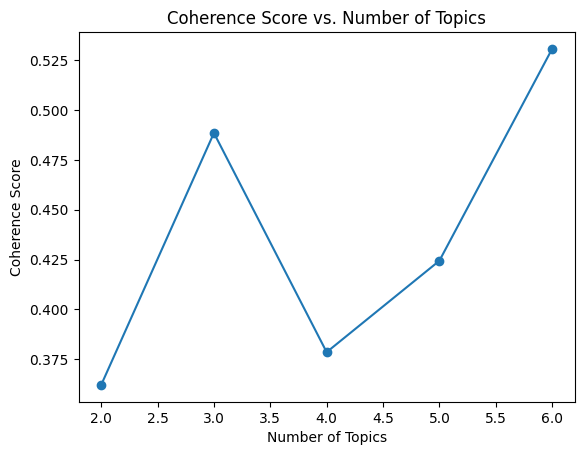

Optimal Number of Topics: 6


In [63]:
import numpy as np
from gensim import corpora, models
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from kneed import KneeLocator
import re

# Initialize empty lists to store coherence scores
coherence_scores = []
topic_nums = range(2, 7)

m7_df['preprocessed_content'] = m7_df['content'].apply(preprocess_text)
texts = [doc.split() for doc in m7_df['preprocessed_content']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

for num_topics in topic_nums:
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()

    # Append coherence score to the list
    coherence_scores.append(coherence_score)


# Plot coherence scores
plt.plot(topic_nums, coherence_scores, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.show()

# Find the optimal number of topics using the elbow method (kelbow)
x = np.array(topic_nums)
y = np.array(coherence_scores)
kl = KneeLocator(x, y, curve='concave', direction='decreasing')
optimal_num_topics = kl.knee

print("Optimal Number of Topics:", optimal_num_topics)

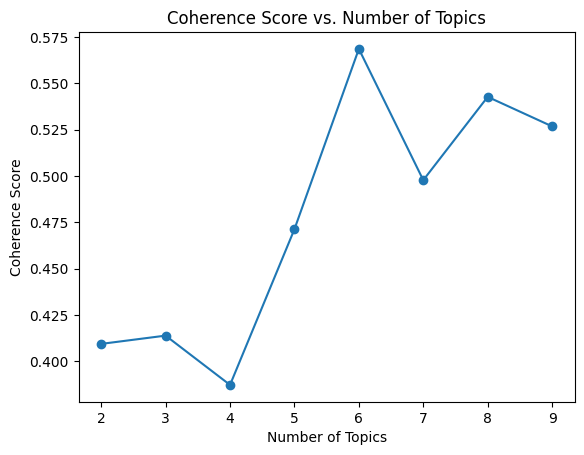

Optimal Number of Topics: 9


In [62]:
import numpy as np
from gensim import corpora, models
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from kneed import KneeLocator
import re

# a30_df, a23_df, a16_df
# Initialize empty lists to store coherence scores
coherence_scores = []
topic_nums = range(2, 10)

a30_df['preprocessed_content'] = a30_df['content'].apply(preprocess_text)
texts = [doc.split() for doc in a30_df['preprocessed_content']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

for num_topics in topic_nums:
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()

    # Append coherence score to the list
    coherence_scores.append(coherence_score)


# Plot coherence scores
plt.plot(topic_nums, coherence_scores, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.show()

# Find the optimal number of topics using the elbow method (kelbow)
x3 = np.array(topic_nums)
y3 = np.array(coherence_scores)
kl3 = KneeLocator(x3, y3, curve='concave', direction='decreasing')
optimal_num_topics = kl3.knee

print("Optimal Number of Topics:", optimal_num_topics)

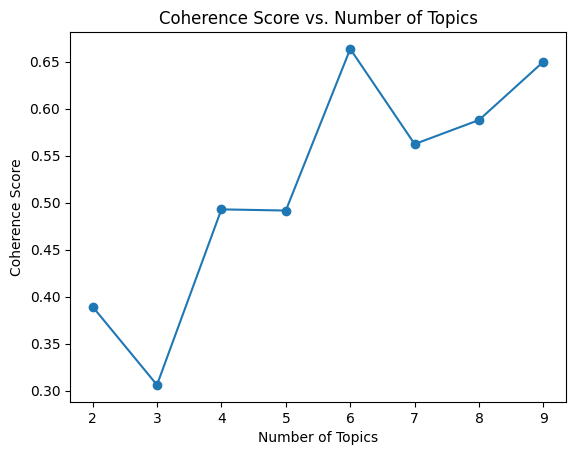

Optimal Number of Topics: 9


In [61]:
import numpy as np
from gensim import corpora, models
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from kneed import KneeLocator
import re

# a30_df, a23_df, a16_df
# Initialize empty lists to store coherence scores
coherence_scores = []
topic_nums = range(2, 10)

a23_df['preprocessed_content'] = a23_df['content'].apply(preprocess_text)
texts = [doc.split() for doc in a23_df['preprocessed_content']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

for num_topics in topic_nums:
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()

    # Append coherence score to the list
    coherence_scores.append(coherence_score)


# Plot coherence scores
plt.plot(topic_nums, coherence_scores, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.show()

# Find the optimal number of topics using the elbow method (kelbow)
x2 = np.array(topic_nums)
y2 = np.array(coherence_scores)
kl2 = KneeLocator(x2, y2, curve='concave', direction='decreasing')
optimal_num_topics = kl2.knee

print("Optimal Number of Topics:", optimal_num_topics)

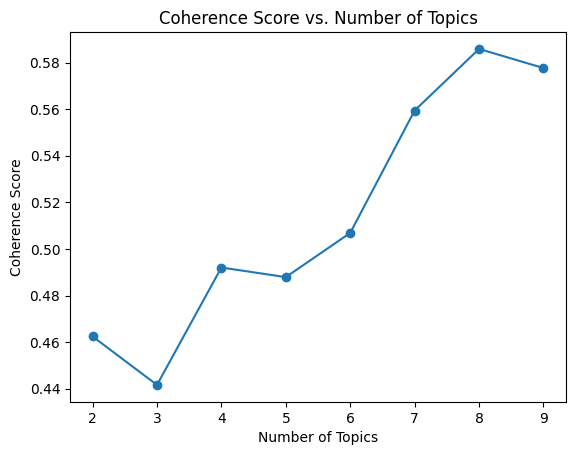

Optimal Number of Topics: 9


In [60]:
import numpy as np
from gensim import corpora, models
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from kneed import KneeLocator
import re

# a30_df, a23_df, a16_df
# Initialize empty lists to store coherence scores
coherence_scores = []
topic_nums = range(2, 10)

a16_df['preprocessed_content'] = a16_df['content'].apply(preprocess_text)
texts = [doc.split() for doc in a16_df['preprocessed_content']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

for num_topics in topic_nums:
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()

    # Append coherence score to the list
    coherence_scores.append(coherence_score)


# Plot coherence scores
plt.plot(topic_nums, coherence_scores, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.show()

# Find the optimal number of topics using the elbow method (kelbow)
x4 = np.array(topic_nums)
y4 = np.array(coherence_scores)
kl4 = KneeLocator(x4, y4, curve='concave', direction='decreasing')
optimal_num_topics = kl4.knee

print("Optimal Number of Topics:", optimal_num_topics)